# Introduction

For the 9th Workshop in Biomedical Engineering (http://wbme.fc.ul.pt/) a specific workshop was prepared to showcase how some of IBM Watson's API could be used; given the target audience and the overall themes of the WBME I had the following 

* Use one or more Watson APIs
* Build a use-case which makes sense within the context of the WBME
* Make the workshop interactive but also useful for those just watching
* Have as little software requirements as possible
* Make it useful even after the workshop, which includes being able to distribute it in some way

After some days experimenting with different options I settled on:

* IBM Watson Visual Recognition API
* A dermoscopic database of images that show skin lesions, both benign and malignate: the PH(2) database from the ADDI project (https://www.fc.up.pt/addi/ph2%20database.html).
* Use IBM Data Science Experience to create, share and enable all to work on their one copies with no software requirements by making use of the Jupyter notebook support with enhanced user interface.

The initial developed was done using the `Rmd` format and it only required slight changes; one of the changes required the use of a specific zip file for the PH(2) dataset since the original one was in a RAR file and this compression mechanism isn't supported directly in R, which means that I was decompressing it using a system command, not something feasible when using a Spark execution environment. That was the _only_ change to the original PH(2) archive (which means that there is not actual change in the contents).

I would like to thank the 9th WBME organisers for the opportunity and in particular to all of those who attended the workshop and that actively participated in it; a particular thank you to Sara Lobo (Biomedical Engineering, FCT/NOVA) in which laptop we ended up working together for the final part of the workshop that ended (successfully!) on the Student's Room of the Faculty of Sciences of the University of Lisbon more in the style of a group debugging session than a formal workshop - much to the advantage of all involved.


## Concerning the topic

The use if visual recognition for detection of malignant skin lesions is something that has been studied intensively and has been the topic of many specialised papers and studies. While I've chose this topic due to being aligned with a bio-medical engineering event the goal of the Watson API workshop is to explain how to use the Visual Recognition API, not to build a useful model for something with such implications as melanoma detection.

I've added some relevant bibliography that clearly show the complexity and the possible approaches which are possible, including image pre-processing, the importance of masking, different strategies in terms of classification and many more, for those who want to explore the matter in more depth.

# Setting up the environment

Throughout this paper we will need to use and install some `R` packages, and given the interactive nature of the notebook it is better to add all of those initial requirements in a single code statement, that way we can run it once and be done with it.

In [224]:
## Load the `caret` library, which includes the partitioning function we will use
library(caret)
## Package e1071 is used by `caret` for the confusion matrix
install.packages('e1071', dependencies=TRUE)
# Install needed packages for image conversion
install.packages("bmp")
install.packages("jpeg")
install.packages("pixmap")
## Load the image-related libraries
library(bmp)
library(jpeg)
library(pixmap)
library(jpeg)
library(grid)
## For the REST API
library(jsonlite)
library(httr)

Installing package into ‘/gpfs/global_fs01/sym_shared/YPProdSpark/user/s238-e7c61469e53a3d-d61b00c8d317/R/libs’
(as ‘lib’ is unspecified)
Installing package into ‘/gpfs/global_fs01/sym_shared/YPProdSpark/user/s238-e7c61469e53a3d-d61b00c8d317/R/libs’
(as ‘lib’ is unspecified)
Installing package into ‘/gpfs/global_fs01/sym_shared/YPProdSpark/user/s238-e7c61469e53a3d-d61b00c8d317/R/libs’
(as ‘lib’ is unspecified)
Installing package into ‘/gpfs/global_fs01/sym_shared/YPProdSpark/user/s238-e7c61469e53a3d-d61b00c8d317/R/libs’
(as ‘lib’ is unspecified)


An IBM Bluemix (https://www.ibm.com/cloud-computing/bluemix/) account is needed; during the workshop this was the first step done but the process is simple: sign up and create a free account and get access to the entire catalogue, including Watson APIs.

# Obtaining and preparing the data

The first step we are going to take is downloading the PH(2) database and preparing the data; these step is fundamental in terms of Data Science and we will spend some time going through it step-by-step to make sure that we have all the needed actions properly automated.

The focus on having everything done "in code" is important since it enables repeatability, which is crucial.

## Cleaning up

This seems strange: why clean up when we are just starting? Given that we are in an interactive (and iteractive) environment which keeps data between runs it is assumed that we will want to run the code several times, and this first step is to remove all the files which we will create during this document. If there is nothing created yet it's not a problem: the `unlink` function deletes what exists and if it doesn't it does nothing.

There is a sole exception: we will not delete de compressed archive since it doesn't change and this avoids having to download the same context several times.


In [225]:
## Delete previous runs
zip_dir <-"ph2-training-files"
## If present remove existing archives from previous runs
unlink(zip_dir, recursive=T,force=T)
unlink("training-set-positive.zip", force=T)
unlink("training-set-negative.zip", force=T)
unlink("parameters.json", force=T)
unlink("*.csv", force=T)
unlink("PH2Dataset", force=T, recursive=T)
## Uncomment to delete the database zip as well
## unlink("PH2Dataset.zip", force=T)

## Getting the dataset

The first action is to download the PH(2) database, available as a downloadable compressed archive; we set up some variables - the URL where the file is and the name of the zip file - and check for the zip file locally, bypassing the download if it already existing.

In [226]:
## New dataset
ph2_url  <- "https://www.dropbox.com/s/9a962jfcrs5x4iq/PH2Dataset.zip?dl=0"
ph2_archive <- "PH2Dataset.zip"

### Check for zipped dataset file: if it doesn't exist then download it
if (!file.exists(ph2_archive)) {
    print("Downloading PH(2) archive")
    download.file(ph2_url, destfile=ph2_archive, method="wget")
} else {
    print("File already exists, skipping download")
}


[1] "File already exists, skipping download"


We should have the PH(2) zip zile (and just that file) in our working directory.

In [227]:
dir()

[1] "PH2Dataset.zip"

Now that we have the archive we unzip it.

In [228]:
dir(".")
unzip(ph2_archive)

[1] "PH2Dataset.zip"

## Initial cleanup

The structure of the newly created directory

In [229]:
dir("PH2Dataset")

[1] "PH2 Dataset images" "PH2_dataset.txt"    "PH2_dataset.xlsx"  
[4] "Readme.txt"

Of particular interest to us is the `PH2_dataset.txt` file that contains a text-based description of the obervations. Let's read the file into a variable and examine some of the content.

In [230]:
ph2_txt <- readLines("PH2Dataset/PH2_dataset.txt")
head(ph2_txt)

Warning message in readLines("PH2Dataset/PH2_dataset.txt"):
“incomplete final line found on 'PH2Dataset/PH2_dataset.txt'”

[1] "||   Name || Histological Diagnosis || Clinical Diagnosis || Asymmetry | Pigment Network | Dots/Globules | Streaks | Regression Areas | Blue-Whitish Veil ||           Colors ||"
[2] "|| IMD003 ||                        ||                  0 ||         0 |               T |             A |       A |                A |                 A ||                4 ||"
[3] "|| IMD009 ||                        ||                  0 ||         0 |               T |             A |       A |                A |                 A ||                3 ||"
[4] "|| IMD016 ||                        ||                  0 ||         0 |               T |             T |       A |                A |                 A ||             3  4 ||"
[5] "|| IMD022 ||                        ||                  0 ||         0 |               T |             A |       A |                A |                 A ||                3 ||"
[6] "|| IMD024 ||                        ||                  0 ||         0 |               T |             A |       A |                A |                 A ||             3  4 ||"

It's a file best read using a monospaced font but one can clearly see that it has a header and then the observations, which columns divided by vertical bars; this is something easy for us to understand but not yet ideal to be used programatically, so we will do some transformations to convert it into something that uses a comma to separate the differente fields - a CSV file which can be directly imported into R, and which we will write to disk (something optional since we could just use the result of the transformations directly).

In [231]:
## Convert the txt to a csv file; due to the format this requires
## several operations.
ph2_new <- gsub ("^\\|\\|", "", fixed=FALSE,ph2_txt[1:201]) # Delete the || in the beginning of the file 
ph2_new <- gsub ("\\|\\|$", "", fixed=FALSE,ph2_new)        # Delete the || at the end of the file
ph2_new <- gsub ("||", ",", fixed=T,ph2_new)                # Replace all the remaining || with a comma
ph2_new <- gsub ("|", ",", fixed=T,ph2_new)                 # Replace all the | with a comma

## Save the result to a file
writeLines(ph2_new, "ph2_dataset.csv")
## ... and read that file into a variable
ph2_table <- read.csv("ph2_dataset.csv", header=T)

We now have a CSV file in our working directory,

In [232]:
dir()

[1] "PH2Dataset"      "ph2_dataset.csv" "PH2Dataset.zip"

... and a `ph2_table` variable which is an R data frame resulting from the import of the CSV file.

In [233]:
str(ph2_table)
head(ph2_table)

'data.frame':	200 obs. of  10 variables:
 $ Name                  : Factor w/ 200 levels " IMD002 "," IMD003 ",..: 2 6 11 17 19 20 26 29 33 35 ...
 $ Histological.Diagnosis: Factor w/ 7 levels "                        ",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Clinical.Diagnosis    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Asymmetry             : num  0 0 0 0 0 0 2 0 0 0 ...
 $ Pigment.Network       : Factor w/ 2 levels "              AT ",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Dots.Globules         : Factor w/ 3 levels "             A ",..: 1 1 3 1 1 3 1 3 3 3 ...
 $ Streaks               : Factor w/ 2 levels "       A ","       P ": 1 1 1 1 1 1 1 1 1 1 ...
 $ Regression.Areas      : Factor w/ 2 levels "                A ",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Blue.Whitish.Veil     : Factor w/ 2 levels "                 A ",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Colors                : Factor w/ 28 levels "       1  2  4  5 ",..: 22 15 16 15 16 15 10 25 16 23 ...


Name     Histological.Diagnosis   Clinical.Diagnosis Asymmetry
1  IMD003                           0                  0        
2  IMD009                           0                  0        
3  IMD016                           0                  0        
4  IMD022                           0                  0        
5  IMD024                           0                  0        
6  IMD025                           0                  0        
  Pigment.Network   Dots.Globules   Streaks   Regression.Areas  
1                T               A         A                  A 
2                T               A         A                  A 
3                T               T         A                  A 
4                T               A         A                  A 
5                T               A         A                  A 
6                T               T         A                  A 
  Blue.Whitish.Veil   Colors            
1                  A                  4 
2                  A                  3 
3                  A               3  4 
4                  A                  3 
5                  A               3  4 
6                  A                  3

## Creating the training and testing sets

Some columns are interpreted as numeric although they are factors; additionally we remove the "atypical nevus" images since for our purposes a smaller dataset is desirable since we want to keep the training time of the model small enough and also avoid reaching the daily allowance of images; this has the effect of removing a group of images which are ambiguous and will certainly result in a model which is simples in the sense that it works has been trained with less corner cases.

In [234]:
ph2_table$Clinical.Diagnosis <- as.factor(ph2_table$Clinical.Diagnosis)
ph2_table$Asymmetry <- as.factor(ph2_table$Asymmetry)
ph2 <- ph2_table[!ph2_table$Clinical.Diagnosis == "1", ]
ph2$Clinical.Diagnosis <- droplevels(ph2$Clinical.Diagnosis)

In [235]:
## We only have two factors now
print(ph2$Clinical.Diagnosis)

  [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [75] 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2
Levels: 0 2


We now split the training data into two different sets, training (70%) and testing (30%), using the Clinical Diagnosis as the outcome

In [236]:
inTrain <- createDataPartition(y=ph2$Clinical.Diagnosis, p=0.7, list=FALSE)
training_set <- ph2[inTrain, ]
testing_set <-  ph2[-inTrain, ]

In [237]:
## See what we have so far
head(training_set)
head(testing_set)

Name     Histological.Diagnosis   Clinical.Diagnosis Asymmetry
1  IMD003                           0                  0        
2  IMD009                           0                  0        
3  IMD016                           0                  0        
5  IMD024                           0                  0        
7  IMD035                           0                  2        
8  IMD038                           0                  0        
  Pigment.Network   Dots.Globules   Streaks   Regression.Areas  
1                T               A         A                  A 
2                T               A         A                  A 
3                T               T         A                  A 
5                T               A         A                  A 
7                T               A         A                  A 
8                T               T         A                  A 
  Blue.Whitish.Veil   Colors            
1                  A                  4 
2                  A                  3 
3                  A               3  4 
5                  A               3  4 
7                  A               2  3 
8                  A               4  6

Name     Histological.Diagnosis   Clinical.Diagnosis Asymmetry
4   IMD022                           0                  0        
6   IMD025                           0                  0        
9   IMD042                           0                  0        
12  IMD050                           0                  0        
14  IMD101                           0                  0        
30  IMD162                           0                  0        
   Pigment.Network   Dots.Globules   Streaks   Regression.Areas  
4                 T               A         A                  A 
6                 T               T         A                  A 
9                 T               T         A                  A 
12                T               T         A                  A 
14                T               A         A                  A 
30                T               T         A                  A 
   Blue.Whitish.Veil   Colors            
4                   A                  3 
6                   A                  3 
9                   A               3  4 
12                  A                  3 
14                  A                  3 
30                  A               3  4

Our approach is straightforward and does not consider the need for
oversampling/bootstraping: we will use the same proportion present in
the pruned dataset.

[1] "Common Nevus: 67%"
[1] "Melanoma: 33%"


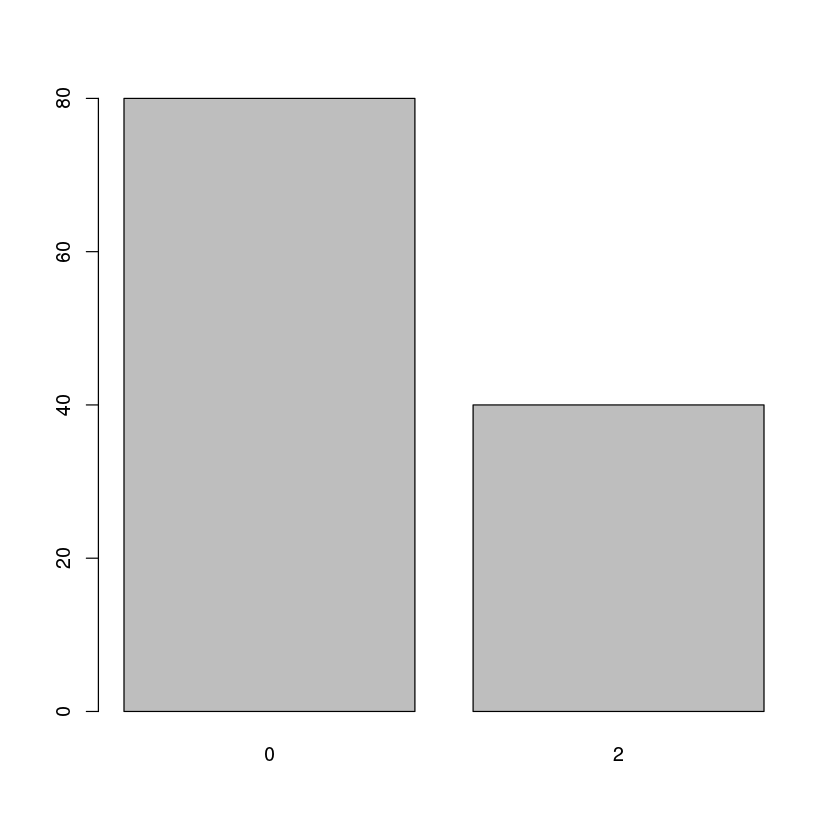

In [238]:
print(sprintf("Common Nevus: %s%%", round(nrow(ph2[ph2$Clinical.Diagnosis == "0", ]) / nrow(ph2) *100, 0)))
print(sprintf("Melanoma: %s%%",     round(nrow(ph2[ph2$Clinical.Diagnosis == "2", ]) / nrow(ph2) *100, 0)))
## Plot
barplot(table(ph2$Clinical.Diagnosis))

## Positive and negative

To use IBM Watson's Visual Recognition we need both positive and
negative sets to test the network; we will use our training set and
divide it into a positive set which includes the melanoma diagnosis
and a negative one which includes the rest.


[1] "Total number of cases in training set: 84"

[1] "Total number of bening cases in training set: 56"

[1] "Total number of malignant cases in training set: 28"

[1] "Common Nevus: 67%"
[1] "Melanoma: 33%"


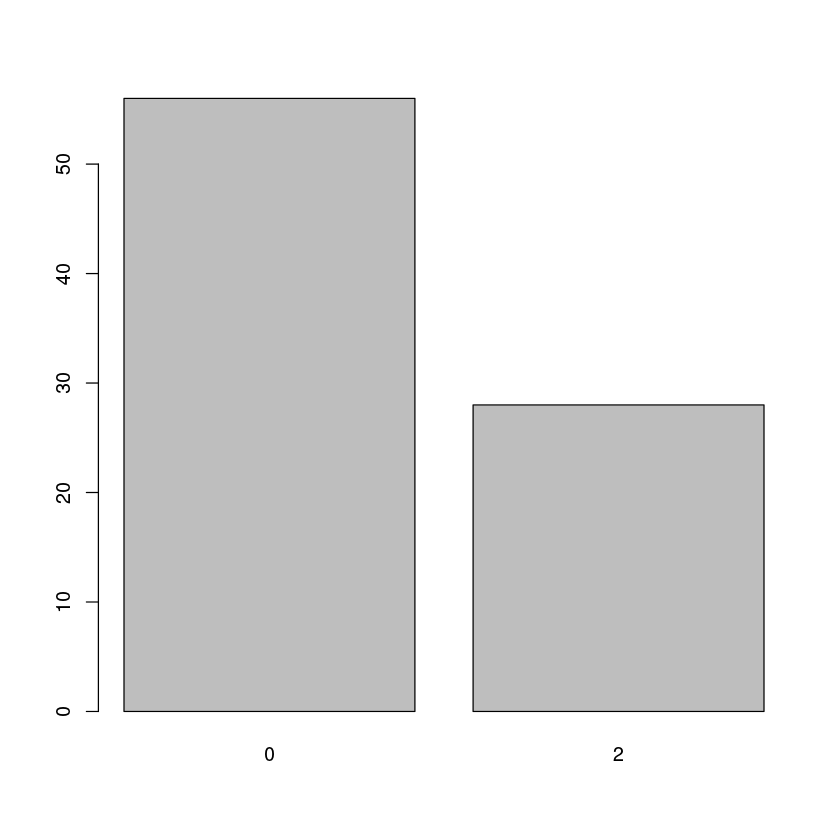

In [239]:
## Total number of cases
sprintf("Total number of cases in training set: %d",nrow(training_set))
## Benign and malignal cases in the training set

sprintf("Total number of bening cases in training set: %d", nrow(training_set[training_set$Clinical.Diagnosis == "0",]))
sprintf("Total number of malignant cases in training set: %d", nrow(training_set[training_set$Clinical.Diagnosis == "2",]))

## Calculate the percentages...
print(sprintf("Common Nevus: %s%%", round(nrow(training_set[training_set$Clinical.Diagnosis == "0", ]) / nrow(training_set) *100, 0)))
print(sprintf("Melanoma: %s%%",     round(nrow(training_set[training_set$Clinical.Diagnosis == "2", ]) / nrow(training_set) *100, 0)))

## ... and plot them
barplot(table(training_set$Clinical.Diagnosis))

## Create variables for both sets to make it clearer
training_positive <- (training_set[training_set$Clinical.Diagnosis == "2",])
training_negative <- (training_set[training_set$Clinical.Diagnosis == "0",])


## Files and paths

The Visual Recognition API accepts the images as a zip file so we use
the image names to build the adequate archives, but before let's explore the database through the directory structure in a bit more detail.

As we saw we have at the toplevel some files and a directory:

In [240]:
dir("PH2Dataset")

[1] "PH2 Dataset images" "PH2_dataset.txt"    "PH2_dataset.xlsx"  
[4] "Readme.txt"

Inside the images directory there are other directories, one for each file. We will use an option to `dir` to obtain the full path of the files and directories to make it clearer.

In [241]:
dir("PH2Dataset/PH2 Dataset images", full.names=T)

[1] "PH2Dataset/PH2 Dataset images/IMD002"
  [2] "PH2Dataset/PH2 Dataset images/IMD003"
  [3] "PH2Dataset/PH2 Dataset images/IMD004"
  [4] "PH2Dataset/PH2 Dataset images/IMD006"
  [5] "PH2Dataset/PH2 Dataset images/IMD008"
  [6] "PH2Dataset/PH2 Dataset images/IMD009"
  [7] "PH2Dataset/PH2 Dataset images/IMD010"
  [8] "PH2Dataset/PH2 Dataset images/IMD013"
  [9] "PH2Dataset/PH2 Dataset images/IMD014"
 [10] "PH2Dataset/PH2 Dataset images/IMD015"
 [11] "PH2Dataset/PH2 Dataset images/IMD016"
 [12] "PH2Dataset/PH2 Dataset images/IMD017"
 [13] "PH2Dataset/PH2 Dataset images/IMD018"
 [14] "PH2Dataset/PH2 Dataset images/IMD019"
 [15] "PH2Dataset/PH2 Dataset images/IMD020"
 [16] "PH2Dataset/PH2 Dataset images/IMD021"
 [17] "PH2Dataset/PH2 Dataset images/IMD022"
 [18] "PH2Dataset/PH2 Dataset images/IMD023"
 [19] "PH2Dataset/PH2 Dataset images/IMD024"
 [20] "PH2Dataset/PH2 Dataset images/IMD025"
 [21] "PH2Dataset/PH2 Dataset images/IMD027"
 [22] "PH2Dataset/PH2 Dataset images/IMD030"
 [23] "PH2Dataset/PH2 Dataset images/IMD031"
 [24] "PH2Dataset/PH2 Dataset images/IMD032"
 [25] "PH2Dataset/PH2 Dataset images/IMD033"
 [26] "PH2Dataset/PH2 Dataset images/IMD035"
 [27] "PH2Dataset/PH2 Dataset images/IMD036"
 [28] "PH2Dataset/PH2 Dataset images/IMD037"
 [29] "PH2Dataset/PH2 Dataset images/IMD038"
 [30] "PH2Dataset/PH2 Dataset images/IMD039"
 [31] "PH2Dataset/PH2 Dataset images/IMD040"
 [32] "PH2Dataset/PH2 Dataset images/IMD041"
 [33] "PH2Dataset/PH2 Dataset images/IMD042"
 [34] "PH2Dataset/PH2 Dataset images/IMD043"
 [35] "PH2Dataset/PH2 Dataset images/IMD044"
 [36] "PH2Dataset/PH2 Dataset images/IMD045"
 [37] "PH2Dataset/PH2 Dataset images/IMD047"
 [38] "PH2Dataset/PH2 Dataset images/IMD048"
 [39] "PH2Dataset/PH2 Dataset images/IMD049"
 [40] "PH2Dataset/PH2 Dataset images/IMD050"
 [41] "PH2Dataset/PH2 Dataset images/IMD057"
 [42] "PH2Dataset/PH2 Dataset images/IMD058"
 [43] "PH2Dataset/PH2 Dataset images/IMD061"
 [44] "PH2Dataset/PH2 Dataset images/IMD063"
 [45] "PH2Dataset/PH2 Dataset images/IMD064"
 [46] "PH2Dataset/PH2 Dataset images/IMD065"
 [47] "PH2Dataset/PH2 Dataset images/IMD075"
 [48] "PH2Dataset/PH2 Dataset images/IMD076"
 [49] "PH2Dataset/PH2 Dataset images/IMD078"
 [50] "PH2Dataset/PH2 Dataset images/IMD080"
 [51] "PH2Dataset/PH2 Dataset images/IMD085"
 [52] "PH2Dataset/PH2 Dataset images/IMD088"
 [53] "PH2Dataset/PH2 Dataset images/IMD090"
 [54] "PH2Dataset/PH2 Dataset images/IMD091"
 [55] "PH2Dataset/PH2 Dataset images/IMD092"
 [56] "PH2Dataset/PH2 Dataset images/IMD101"
 [57] "PH2Dataset/PH2 Dataset images/IMD103"
 [58] "PH2Dataset/PH2 Dataset images/IMD105"
 [59] "PH2Dataset/PH2 Dataset images/IMD107"
 [60] "PH2Dataset/PH2 Dataset images/IMD108"
 [61] "PH2Dataset/PH2 Dataset images/IMD112"
 [62] "PH2Dataset/PH2 Dataset images/IMD118"
 [63] "PH2Dataset/PH2 Dataset images/IMD120"
 [64] "PH2Dataset/PH2 Dataset images/IMD125"
 [65] "PH2Dataset/PH2 Dataset images/IMD126"
 [66] "PH2Dataset/PH2 Dataset images/IMD132"
 [67] "PH2Dataset/PH2 Dataset images/IMD133"
 [68] "PH2Dataset/PH2 Dataset images/IMD134"
 [69] "PH2Dataset/PH2 Dataset images/IMD135"
 [70] "PH2Dataset/PH2 Dataset images/IMD137"
 [71] "PH2Dataset/PH2 Dataset images/IMD138"
 [72] "PH2Dataset/PH2 Dataset images/IMD139"
 [73] "PH2Dataset/PH2 Dataset images/IMD140"
 [74] "PH2Dataset/PH2 Dataset images/IMD142"
 [75] "PH2Dataset/PH2 Dataset images/IMD143"
 [76] "PH2Dataset/PH2 Dataset images/IMD144"
 [77] "PH2Dataset/PH2 Dataset images/IMD146"
 [78] "PH2Dataset/PH2 Dataset images/IMD147"
 [79] "PH2Dataset/PH2 Dataset images/IMD149"
 [80] "PH2Dataset/PH2 Dataset images/IMD150"
 [81] "PH2Dataset/PH2 Dataset images/IMD152"
 [82] "PH2Dataset/PH2 Dataset images/IMD153"
 [83] "PH2Dataset/PH2 Dataset images/IMD154"
 [84] "PH2Dataset/PH2 Dataset images/IMD155"
 [85] "PH2Dataset/PH2 Dataset images/IMD156"
 [86] "PH2Dataset/PH2 Dataset images/IMD157"
 [87] "PH2Dataset/PH2 Dataset images/IMD159"
 [88] "PH2Dataset/PH2 Dataset images/IMD160"
 [89] "PH2Dataset/PH2 Dataset images/IMD16

Each of these directories has a similar structure, and we will use a random one to list all the contents.

In [242]:
name_sample <- training_set[sample.int(nrow(training_set),1), ]
name_sample$Name

[1]  IMD150 
200 Levels:  IMD002   IMD003   IMD004   IMD006   IMD008   IMD009  ...  IMD437

To get there we just need to build the file path - this will be very important in the next step - by simply appending the file name to the images directory.

In [243]:
dir(sprintf("PH2Dataset/PH2 Dataset images/%s", name_sample$Name), full.names=T, recursive=T)

character(0)

Is that directory empty? We actually know it isn't (you can download the archive and check it yourself), so what happened? The answer lies in the `Name` field: if we check it a bit better we can see that it contains extra characters.

In [244]:
sprintf("PH2Dataset/PH2 Dataset images/%s", name_sample$Name)

[1] "PH2Dataset/PH2 Dataset images/ IMD150 "

Since we didn't clean the `Name` column properly it contains extra whitespace, which is passed into `dir`. The solution is to trim all the names, removing any whitespace.

Note that this, as many other actions we will perform, would be better done to the initial `ph2_table` data frame that contains the complete number of observations and from which we would then extract the needed datasets, but since we're learning as we go we will correct the derived datasets seperately.

In [245]:
## Trim function: remove unneeded whitespace
trim <- function (x) gsub("^\\s+|\\s+$", "", x)
training_set$Name <- trim(training_set$Name)
testing_set$Name <- trim(testing_set$Name)

With this fixed let's see how it works.

In [246]:
## Get a new sample
name_sample <- training_set[sample.int(nrow(training_set),1), ]
## Check the file path
sprintf("PH2Dataset/PH2 Dataset images/%s", name_sample$Name)

[1] "PH2Dataset/PH2 Dataset images/IMD080"

Looks correct so now we can try to obtain the directory listing of the image directory again, and hopefuly it will work now.

In [247]:
dir(sprintf("PH2Dataset/PH2 Dataset images/%s", name_sample$Name), full.names=T, recursive=T)

[1] "PH2Dataset/PH2 Dataset images/IMD080/IMD080_Dermoscopic_Image/IMD080.bmp"
[2] "PH2Dataset/PH2 Dataset images/IMD080/IMD080_lesion/IMD080_lesion.bmp"

Great, it worked.

The image we are going to use if the one in the _Dermoscopy Image_ directory, and we will not use any of the two (one always present, the other optional) additional images made available which are _masks_ which identify the lesion itself from the surrounding tissue. This is explained in the `Readme.txt` file, which should actually be the very first thing we should read in order to understand the database so let's take a look now.

In [248]:
readLines("PH2Dataset/Readme.txt")


Warning message in readLines("PH2Dataset/Readme.txt"):
“incomplete final line found on 'PH2Dataset/Readme.txt'”

 [1] "###############################################################################################################"                                                                   
 [2] "\t\t\t\t\t\t \tReadme"                                                                                                                                                             
 [3] "###############################################################################################################"                                                                   
 [4] "PH\xb2 Dataset contents:"                                                                                                                                                          
 [5] ""                                                                                                                                                                                  
 [6] "PH\xb2 Dataset images folder: Inside this folder there is a dedi

We are now able to add a correct file image path to each observation and so we add a new column - `File` - that contains that information.

In [249]:
## Trim the entries in the positive and negative sets
training_positive$Name <- trim(training_positive$Name)
training_negative$Name <- trim(training_negative$Name)
## Add the file image path to each observation
training_positive$File <- sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.bmp", training_positive$Name, training_positive$Name, training_positive$Name)
training_negative$File <- sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.bmp", training_negative$Name, training_negative$Name, training_negative$Name)
## Since we could forget about this latter we will do the same to the testing set right now
testing_set$File <- sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.bmp", testing_set$Name, testing_set$Name, testing_set$Name)

We can now see that we have the file path in an additional column

In [250]:
head(training_positive)
head(training_negative)
head(testing_set)

Name   Histological.Diagnosis   Clinical.Diagnosis Asymmetry
162 IMD061                          2                  2        
163 IMD063                Melanoma  2                  2        
165 IMD065                          2                  2        
166 IMD080                Melanoma  2                  2        
167 IMD085                          2                  2        
168 IMD088                Melanoma  2                  2        
    Pigment.Network   Dots.Globules   Streaks   Regression.Areas  
162               AT               A         A                  P 
163               AT              AT         A                  A 
165               AT               A         A                  P 
166               AT               A         P                  P 
167               AT               A         A                  A 
168               AT              AT         P                  P 
    Blue.Whitish.Veil   Colors            
162                  P               3  5 
163                  P               3  4 
165                  P               4  6 
166                  P            2  4  6 
167                  P               5  6 
168                  P         1  4  5  6 
    File                                                                    
162 PH2Dataset/PH2 Dataset images/IMD061/IMD061_Dermoscopic_Image/IMD061.bmp
163 PH2Dataset/PH2 Dataset images/IMD063/IMD063_Dermoscopic_Image/IMD063.bmp
165 PH2Dataset/PH2 Dataset images/IMD065/IMD065_Dermoscopic_Image/IMD065.bmp
166 PH2Dataset/PH2 Dataset images/IMD080/IMD080_Dermoscopic_Image/IMD080.bmp
167 PH2Dataset/PH2 Dataset images/IMD085/IMD085_Dermoscopic_Image/IMD085.bmp
168 PH2Dataset/PH2 Dataset images/IMD088/IMD088_Dermoscopic_Image/IMD088.bmp

Name   Histological.Diagnosis   Clinical.Diagnosis Asymmetry
1 IMD003                          0                  0        
2 IMD009                          0                  0        
3 IMD016                          0                  0        
5 IMD024                          0                  0        
7 IMD035                          0                  2        
8 IMD038                          0                  0        
  Pigment.Network   Dots.Globules   Streaks   Regression.Areas  
1                T               A         A                  A 
2                T               A         A                  A 
3                T               T         A                  A 
5                T               A         A                  A 
7                T               A         A                  A 
8                T               T         A                  A 
  Blue.Whitish.Veil   Colors            
1                  A                  4 
2                  A                  3 
3                  A               3  4 
5                  A               3  4 
7                  A               2  3 
8                  A               4  6 
  File                                                                    
1 PH2Dataset/PH2 Dataset images/IMD003/IMD003_Dermoscopic_Image/IMD003.bmp
2 PH2Dataset/PH2 Dataset images/IMD009/IMD009_Dermoscopic_Image/IMD009.bmp
3 PH2Dataset/PH2 Dataset images/IMD016/IMD016_Dermoscopic_Image/IMD016.bmp
5 PH2Dataset/PH2 Dataset images/IMD024/IMD024_Dermoscopic_Image/IMD024.bmp
7 PH2Dataset/PH2 Dataset images/IMD035/IMD035_Dermoscopic_Image/IMD035.bmp
8 PH2Dataset/PH2 Dataset images/IMD038/IMD038_Dermoscopic_Image/IMD038.bmp

Name   Histological.Diagnosis   Clinical.Diagnosis Asymmetry
4  IMD022                          0                  0        
6  IMD025                          0                  0        
9  IMD042                          0                  0        
12 IMD050                          0                  0        
14 IMD101                          0                  0        
30 IMD162                          0                  0        
   Pigment.Network   Dots.Globules   Streaks   Regression.Areas  
4                 T               A         A                  A 
6                 T               T         A                  A 
9                 T               T         A                  A 
12                T               T         A                  A 
14                T               A         A                  A 
30                T               T         A                  A 
   Blue.Whitish.Veil   Colors            
4                   A                  3 
6                   A                  3 
9                   A               3  4 
12                  A                  3 
14                  A                  3 
30                  A               3  4 
   File                                                                    
4  PH2Dataset/PH2 Dataset images/IMD022/IMD022_Dermoscopic_Image/IMD022.bmp
6  PH2Dataset/PH2 Dataset images/IMD025/IMD025_Dermoscopic_Image/IMD025.bmp
9  PH2Dataset/PH2 Dataset images/IMD042/IMD042_Dermoscopic_Image/IMD042.bmp
12 PH2Dataset/PH2 Dataset images/IMD050/IMD050_Dermoscopic_Image/IMD050.bmp
14 PH2Dataset/PH2 Dataset images/IMD101/IMD101_Dermoscopic_Image/IMD101.bmp
30 PH2Dataset/PH2 Dataset images/IMD162/IMD162_Dermoscopic_Image/IMD162.bmp

## Image format conversion

Everything looks fine... but there's nothing like making sure things are actually working so we will try to load and display an image from two random samples.

Warning message in rep(cellres, length = 2):
“'x' is NULL so the result will be NULL”Warning message in rep(cellres, length = 2):
“'x' is NULL so the result will be NULL”

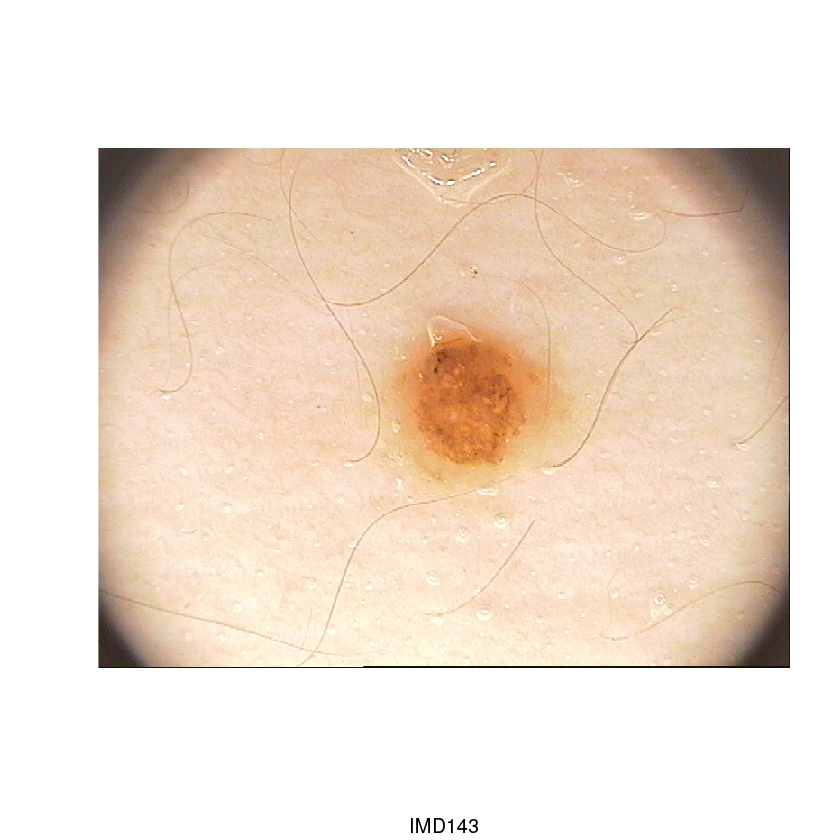

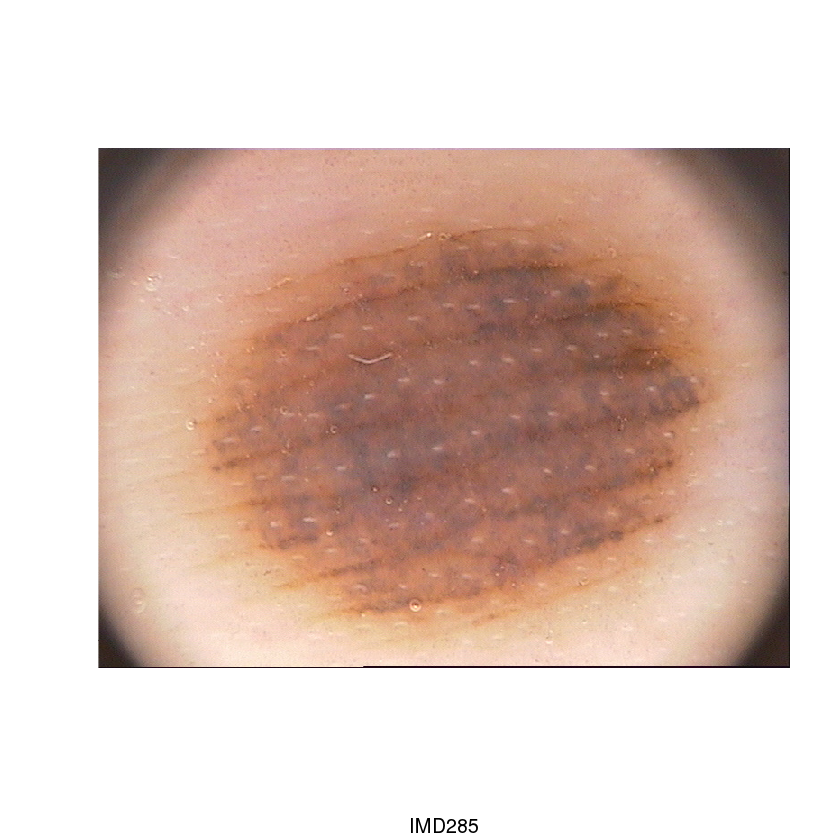

In [251]:
## Pick a random sample from the training set
negative_sample <- training_negative[sample.int(nrow(training_negative),1), ]
positive_sample <- training_positive[sample.int(nrow(training_positive),1), ]

## Use read.bmp to read the image and then create a pixmapRGB object that can be "plotted"
negative_image <- pixmapRGB(read.bmp(negative_sample$File))
positive_image <- pixmapRGB(read.bmp(positive_sample$File))

## We use plot to display the image, and par to display them in a single row, side by side
##par(mfrow=c(1,2))
plot(negative_image, sub = negative_sample$Name)
plot(positive_image, sub = positive_sample$Name)

Now that we have confirmed that the image paths are correct we need to build the zip archives; Watson Visual recognition receives the images as zip files which contain all the images that will be used to build the model.

First we create some auxiliary directories that will be used to make the two zip files.

In [252]:
zip_dir <-"ph2-training-files"
positive_dir <- file.path(zip_dir,"positive")
negative_dir <- file.path(zip_dir,"negative")

dir.create(zip_dir)
dir.create(positive_dir)
dir.create(negative_dir)
dir(zip_dir)

[1] "negative" "positive"

We just need to copy the images and create the zip right? Actually, there is still one important thing missing: Visual Recognition accepts files in JPEG and PNG format, and the PH(2) dataset has the files as BMP. We need to convert them first, something that is also possible with some additional R libraries.

Each image will be read, converted to JPEG and saved in the same directory as the original, and we will then copy them to specific directories that will be used to build the _positive_ and _negative_ archives. These approach has the advantage of working for the testing set without any change - remember that there is no "positive" or "negative" split in the testing set.

Do note that, as always, there are many different ways to go about this transformation; in the initial version the `magick` library was used and it makes the process quite straightforward and arguably more readable. The downside is that it depends on external libraries that make it less portable, hence the use of the `jpeg` and `bmp` libraries.

Warning message in rep(cellres, length = 2):
“'x' is NULL so the result will be NULL”

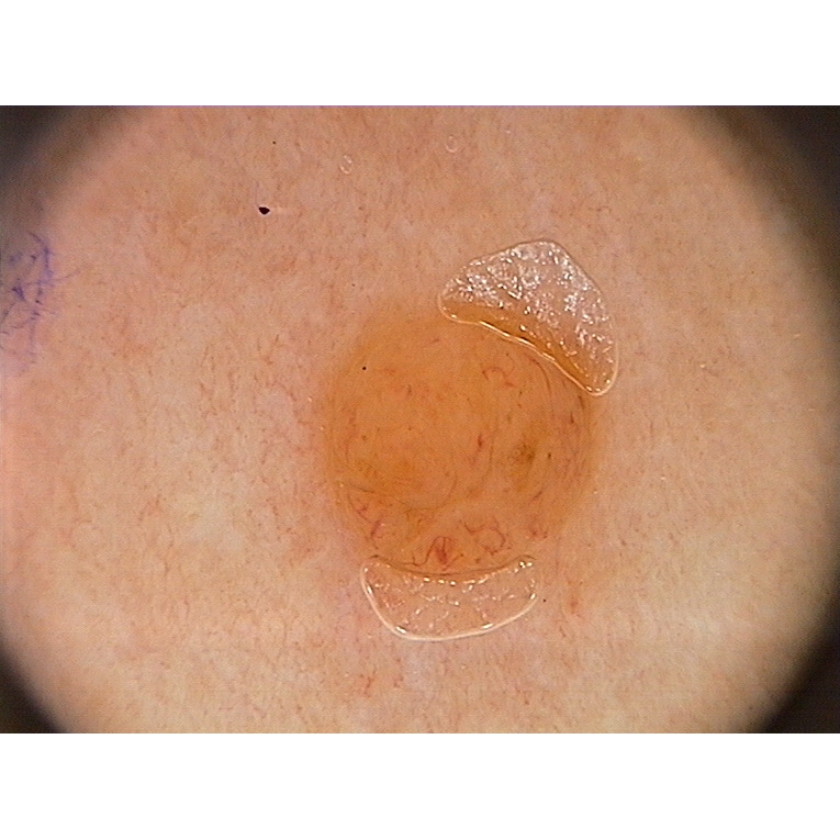

In [253]:
## Pick a new sample
negative_sample <- training_negative[sample.int(nrow(training_negative),1), ]
negative_image <- pixmapRGB(read.bmp(negative_sample$File))
##Write the JPEG
writeJPEG(getChannels(negative_image), target =  sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.jpg", negative_sample$Name, negative_sample$Name, negative_sample$Name), quality = 1)

## Read the JPEG
jpeg <- readJPEG(sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.jpg", negative_sample$Name, negative_sample$Name, negative_sample$Name))

## Display the JPEG
grid.raster(jpeg)

Now that we have a way to convert to JPEG we will convert all the images; this means looping through all observations, and for that we make a function that encapsulates the conversion process.

In [254]:
## This function converts a given image (provided as the name, without extension) to JPEG and saves it as a side-effect before returning the JPEG image as the return value.
bmp_to_jpeg <- function (name) {
    ## Disable warnings from pixmapRGB
    oldw <- getOption("warn")
    options(warn = -1)

    ## Read the BMP file
    bmp_image <- pixmapRGB(read.bmp(sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.bmp", name, name, name)))
    ## Write the JPEG
    writeJPEG(getChannels(bmp_image), target =  sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.jpg", name, name, name), quality = 1)
    options(warn = oldw)
}

Now that we can read a BMP file, convert into JPEG and save it we just need to apply these steps to all cases in the datasets

In [255]:
## Apply the transformation to all rows
for (i in 1:nrow(training_positive))
{
   bmp_to_jpeg(training_positive[i,"Name"])   
}
print("Done")

[1] "Done"


Now we should have a JPEG image along the original BMP file

[1] "IMD413.bmp" "IMD413.jpg"

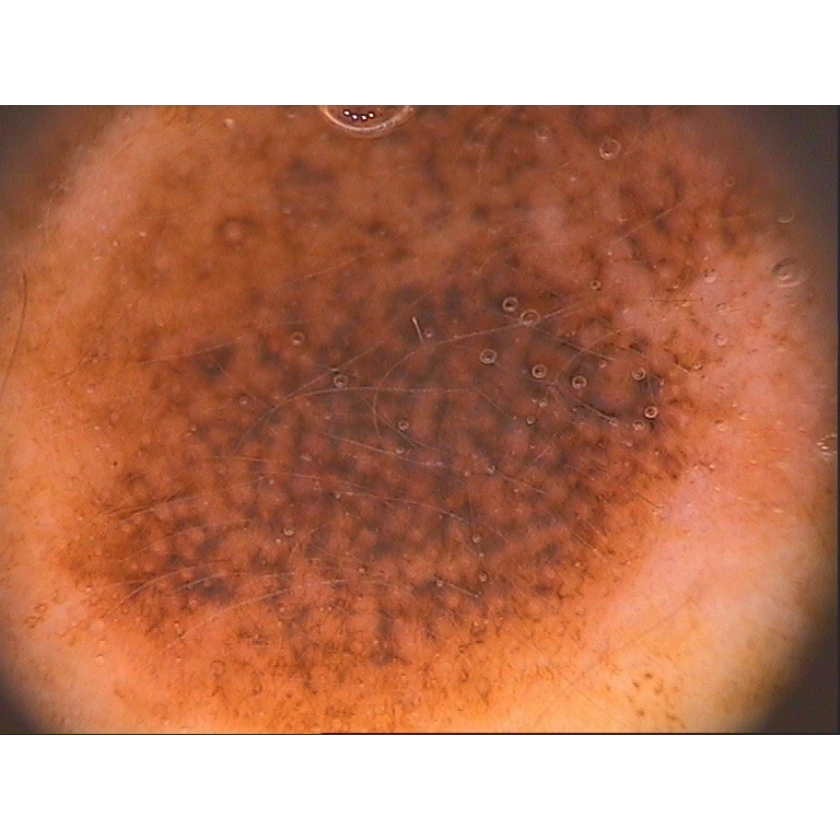

In [256]:
## Pick another sample and check if there
positive_sample <- training_positive[sample.int(nrow(training_positive),1), ]
dir(sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/", positive_sample$Name, positive_sample$Name))

## Read the JPEG
jpeg <- readJPEG(sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.jpg", positive_sample$Name, positive_sample$Name, positive_sample$Name))
## Display the JPEG
grid.raster(jpeg)

Now that we have all the images in the positive set as JPEG we need to do the same to the rest of the images - remember, this would be something that could and should be done to the original `ph2_table` since it would only have to be done once.

In [257]:
## Do the same for the negative example
for (i in 1:nrow(training_negative))
{
   bmp_to_jpeg(training_negative[i,"Name"])
}
print("Done")

[1] "Done"


We also check if it worked for this set:

[1] "IMD207.bmp" "IMD207.jpg"

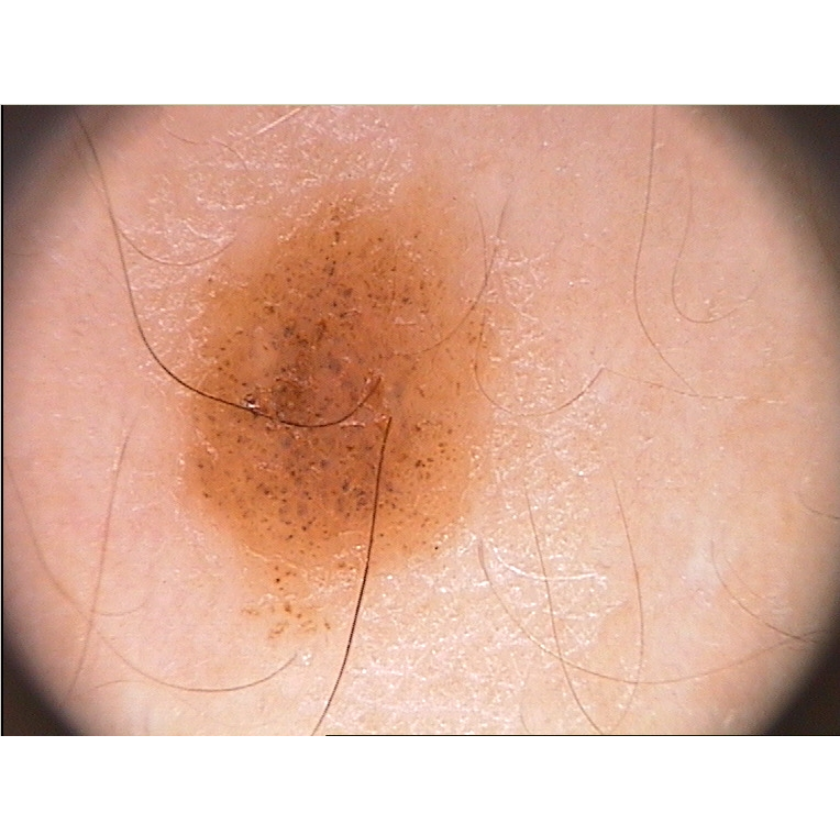

In [258]:
negative_sample <- training_negative[sample.int(nrow(training_negative),1), ]
dir(sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/", negative_sample$Name, negative_sample$Name))

## Read the JPEG
jpeg <- readJPEG(sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.jpg", negative_sample$Name, negative_sample$Name, negative_sample$Name))
## Display the JPEG
grid.raster(jpeg)

We shouldn't forget about the testing set - we will want to submit images for testing and the same restrictions on file format apply.

In [259]:
## Do the same for the testing example
for (i in 1:nrow(testing_set))
{
   bmp_to_jpeg(testing_set[i,"Name"])   
}
print("Done")

[1] "Done"


... and check if it worked.

[1] "IMD108.bmp" "IMD108.jpg"

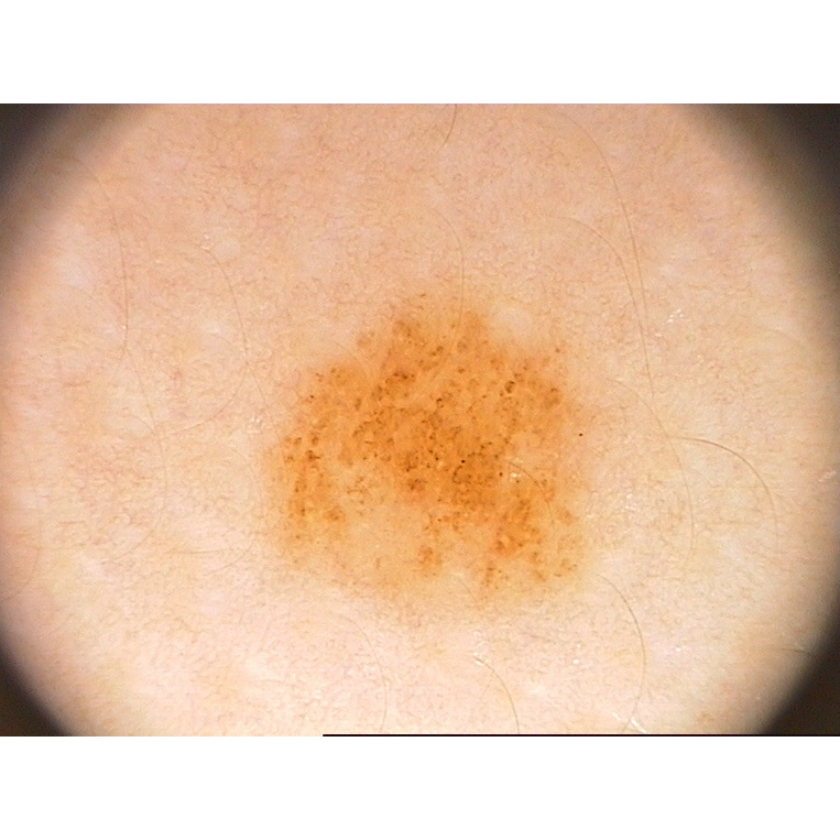

In [260]:
testing_sample <- testing_set[sample.int(nrow(testing_set),1), ]
dir(sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/", testing_sample$Name, testing_sample$Name))

## Read the JPEG
jpeg <- readJPEG(sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.jpg", testing_sample$Name, testing_sample$Name, testing_sample$Name))
## Display the JPEG
grid.raster(jpeg)

The `File` field of each observation points to the BMP file; since we want to operate on the JPEG files that we created we simply replace that field (another option woild be to add a new column, thus keeping a reference to both files). 

[1] "Before changing to JPEG"


Name   Histological.Diagnosis   Clinical.Diagnosis Asymmetry
175 IMD242         Lentigo Maligna  2                  2        
    Pigment.Network   Dots.Globules   Streaks   Regression.Areas  
175               AT               A         A                  A 
    Blue.Whitish.Veil   Colors            
175                  A            3  4  6 
    File                                                                    
175 PH2Dataset/PH2 Dataset images/IMD242/IMD242_Dermoscopic_Image/IMD242.bmp

Name   Histological.Diagnosis   Clinical.Diagnosis Asymmetry
56 IMD207                          0                  0        
   Pigment.Network   Dots.Globules   Streaks   Regression.Areas  
56                T               T         A                  A 
   Blue.Whitish.Veil   Colors            
56                  A               3  4 
   File                                                                    
56 PH2Dataset/PH2 Dataset images/IMD207/IMD207_Dermoscopic_Image/IMD207.bmp

Name   Histological.Diagnosis   Clinical.Diagnosis Asymmetry
14 IMD101                          0                  0        
   Pigment.Network   Dots.Globules   Streaks   Regression.Areas  
14                T               A         A                  A 
   Blue.Whitish.Veil   Colors            
14                  A                  3 
   File                                                                    
14 PH2Dataset/PH2 Dataset images/IMD101/IMD101_Dermoscopic_Image/IMD101.bmp

[1] "After changing to JPEG"


Name   Histological.Diagnosis   Clinical.Diagnosis Asymmetry
199 IMD429                          2                  0        
    Pigment.Network   Dots.Globules   Streaks   Regression.Areas  
199               AT               A         P                  A 
    Blue.Whitish.Veil   Colors            
199                  P         3  4  5  6 
    File                                                                    
199 PH2Dataset/PH2 Dataset images/IMD429/IMD429_Dermoscopic_Image/IMD429.jpg

Name   Histological.Diagnosis   Clinical.Diagnosis Asymmetry
18 IMD125                          0                  0        
   Pigment.Network   Dots.Globules   Streaks   Regression.Areas  
18                T               T         A                  A 
   Blue.Whitish.Veil   Colors            
18                  A               3  4 
   File                                                                    
18 PH2Dataset/PH2 Dataset images/IMD125/IMD125_Dermoscopic_Image/IMD125.jpg

Name   Histological.Diagnosis   Clinical.Diagnosis Asymmetry
180 IMD403                Melanoma  2                  2        
    Pigment.Network   Dots.Globules   Streaks   Regression.Areas  
180               AT               A         A                  P 
    Blue.Whitish.Veil   Colors            
180                  A            1  3  4 
    File                                                                    
180 PH2Dataset/PH2 Dataset images/IMD403/IMD403_Dermoscopic_Image/IMD403.jpg

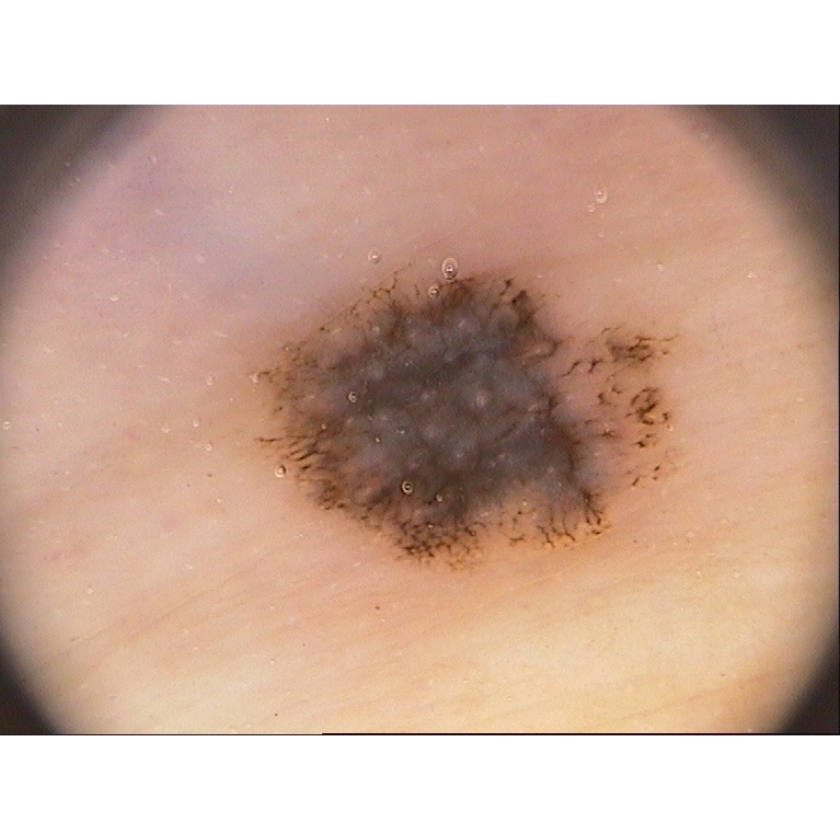

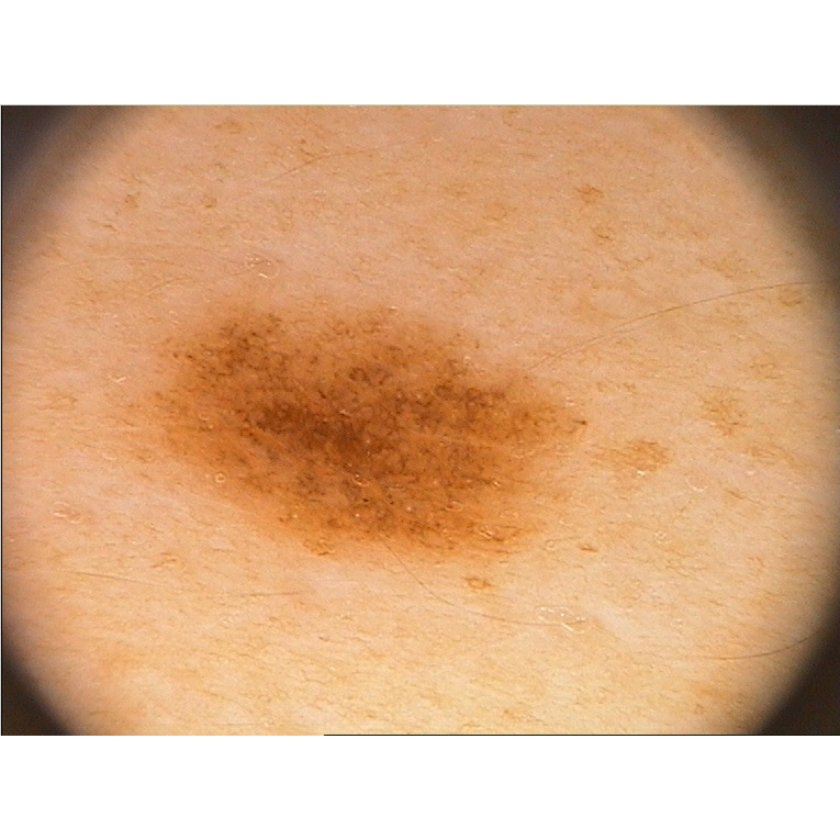

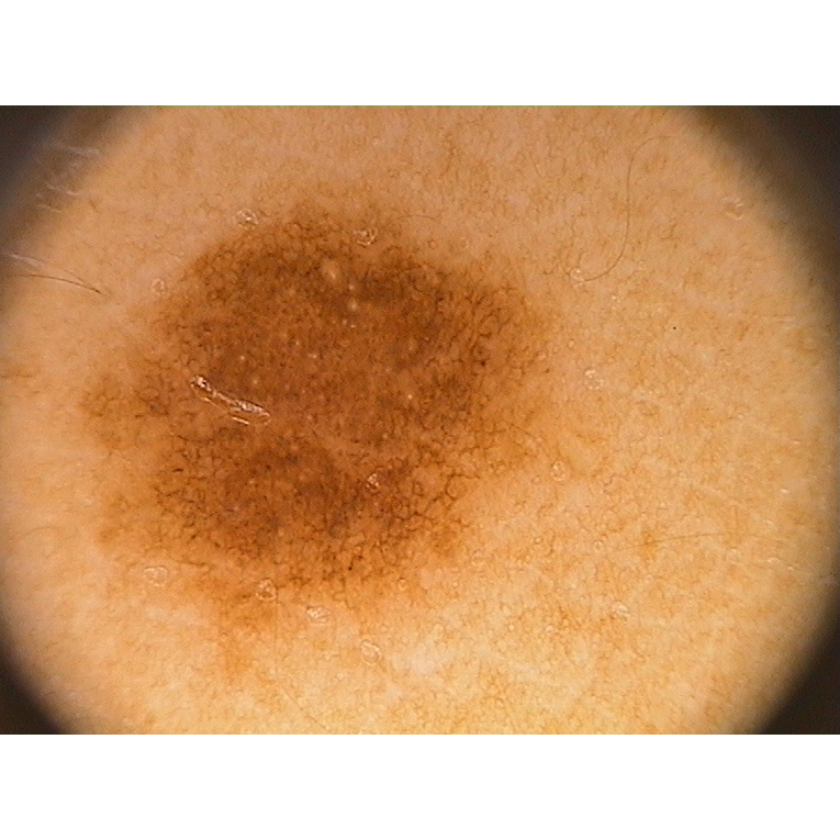

In [261]:
## Get fresh samples again
positive_sample <- training_positive[sample.int(nrow(training_positive),1), ]
negative_sample <- training_negative[sample.int(nrow(training_negative),1), ]
testing_sample <- testing_set[sample.int(nrow(testing_set),1), ]

print("Before changing to JPEG")
head(positive_sample)
head(negative_sample)
head(testing_sample)

training_positive$File <- sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.jpg", training_positive$Name, training_positive$Name, training_positive$Name)
training_negative$File <- sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.jpg", training_negative$Name, training_negative$Name, training_negative$Name)
testing_set$File <- sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.jpg", testing_set$Name, testing_set$Name, testing_set$Name)

positive_sample <- training_positive[sample.int(nrow(training_positive),1), ]
negative_sample <- training_negative[sample.int(nrow(training_negative),1), ]
testing_sample <- testing_set[sample.int(nrow(testing_set),1), ]

print("After changing to JPEG")
head(positive_sample)
head(negative_sample)
head(testing_sample)

## Read the JPEG
#jpeg <- readJPEG(sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.jpg", negative_sample$Name, negative_sample$Name, negative_sample$Name))

## Display the JPEG; we use grid.newpage() since otherwise grid.raster() would only show the last image.
grid.newpage()
grid.raster(readJPEG(positive_sample$File))
grid.newpage()
grid.raster(readJPEG(negative_sample$File))
grid.newpage()
grid.raster(readJPEG(testing_set$File))


## Creating the archives

Let's review some of the steps we've done up until this point:

- Downloaded the PH(2) archive and extracted it
- Imported the description of all observations
- Created the testing and training datasets
- Added the file path to the observations
- Converted all images to JPEG

We're very close to actually starting to use Watson! This preliminary steps are (and I'm stressing this again on purpose) fundamental for any Data Science project: parsing text files and converting images is hardly as attractive as using a Deep Learning framework such as Watson Visual Recognition, but it's a necessary step that when done correctly has a huge positive impact on the ability to repeat and share the experiment.

Watson Visual Recognition trains a model by analysing a zip file with the _positive_ examples, and optionally _negative_ examples. We will use this to train a classifier for melanoma, supplying examples of images which are malignant (the positive archive) and benign (the negative archive).

Remember that we have already created the two directories previously.

In [274]:
dir(zip_dir, full.names=T)

[1] "ph2-training-files/negative" "ph2-training-files/positive"

We can now copy the JPEGs to their respective directory, beginning with the ones form the positive set.

In [275]:
## Copy the images in the positive set
for (i in 1:nrow(training_positive))
{
    print(sprintf("%s -> %s",training_positive[i,"File"],positive_dir))
    file.copy(training_positive[i,"File"],positive_dir)

}
print("Directory listing:")
dir(positive_dir)

[1] "PH2Dataset/PH2 Dataset images/IMD061/IMD061_Dermoscopic_Image/IMD061.jpg -> ph2-training-files/positive"
[1] "PH2Dataset/PH2 Dataset images/IMD063/IMD063_Dermoscopic_Image/IMD063.jpg -> ph2-training-files/positive"
[1] "PH2Dataset/PH2 Dataset images/IMD065/IMD065_Dermoscopic_Image/IMD065.jpg -> ph2-training-files/positive"
[1] "PH2Dataset/PH2 Dataset images/IMD080/IMD080_Dermoscopic_Image/IMD080.jpg -> ph2-training-files/positive"
[1] "PH2Dataset/PH2 Dataset images/IMD085/IMD085_Dermoscopic_Image/IMD085.jpg -> ph2-training-files/positive"
[1] "PH2Dataset/PH2 Dataset images/IMD088/IMD088_Dermoscopic_Image/IMD088.jpg -> ph2-training-files/positive"
[1] "PH2Dataset/PH2 Dataset images/IMD091/IMD091_Dermoscopic_Image/IMD091.jpg -> ph2-training-files/positive"
[1] "PH2Dataset/PH2 Dataset images/IMD211/IMD211_Dermoscopic_Image/IMD211.jpg -> ph2-training-files/positive"
[1] "PH2Dataset/PH2 Dataset images/IMD240/IMD240_Dermoscopic_Image/IMD240.jpg -> ph2-training-files/positive"
[1] "PH2Da

[1] "IMD061.jpg" "IMD063.jpg" "IMD065.jpg" "IMD080.jpg" "IMD085.jpg"
 [6] "IMD088.jpg" "IMD091.jpg" "IMD211.jpg" "IMD240.jpg" "IMD242.jpg"
[11] "IMD284.jpg" "IMD285.jpg" "IMD349.jpg" "IMD404.jpg" "IMD405.jpg"
[16] "IMD406.jpg" "IMD408.jpg" "IMD409.jpg" "IMD411.jpg" "IMD413.jpg"
[21] "IMD418.jpg" "IMD419.jpg" "IMD420.jpg" "IMD423.jpg" "IMD425.jpg"
[26] "IMD426.jpg" "IMD429.jpg" "IMD435.jpg"

... and now the negative set.

In [276]:
## Copy the images in the negative set
for (i in 1:nrow(training_negative))
{
    print(sprintf("%s -> %s",training_negative[i,"File"],negative_dir))
    file.copy(training_negative[i,"File"],negative_dir)

}
print("Directory listing:")
dir(negative_dir)

[1] "PH2Dataset/PH2 Dataset images/IMD003/IMD003_Dermoscopic_Image/IMD003.jpg -> ph2-training-files/negative"
[1] "PH2Dataset/PH2 Dataset images/IMD009/IMD009_Dermoscopic_Image/IMD009.jpg -> ph2-training-files/negative"
[1] "PH2Dataset/PH2 Dataset images/IMD016/IMD016_Dermoscopic_Image/IMD016.jpg -> ph2-training-files/negative"
[1] "PH2Dataset/PH2 Dataset images/IMD024/IMD024_Dermoscopic_Image/IMD024.jpg -> ph2-training-files/negative"
[1] "PH2Dataset/PH2 Dataset images/IMD035/IMD035_Dermoscopic_Image/IMD035.jpg -> ph2-training-files/negative"
[1] "PH2Dataset/PH2 Dataset images/IMD038/IMD038_Dermoscopic_Image/IMD038.jpg -> ph2-training-files/negative"
[1] "PH2Dataset/PH2 Dataset images/IMD044/IMD044_Dermoscopic_Image/IMD044.jpg -> ph2-training-files/negative"
[1] "PH2Dataset/PH2 Dataset images/IMD045/IMD045_Dermoscopic_Image/IMD045.jpg -> ph2-training-files/negative"
[1] "PH2Dataset/PH2 Dataset images/IMD092/IMD092_Dermoscopic_Image/IMD092.jpg -> ph2-training-files/negative"
[1] "PH2Da

[1] "IMD003.jpg" "IMD009.jpg" "IMD010.jpg" "IMD016.jpg" "IMD020.jpg"
 [6] "IMD024.jpg" "IMD035.jpg" "IMD038.jpg" "IMD039.jpg" "IMD041.jpg"
[11] "IMD044.jpg" "IMD045.jpg" "IMD092.jpg" "IMD103.jpg" "IMD105.jpg"
[16] "IMD107.jpg" "IMD112.jpg" "IMD118.jpg" "IMD125.jpg" "IMD132.jpg"
[21] "IMD134.jpg" "IMD135.jpg" "IMD142.jpg" "IMD143.jpg" "IMD144.jpg"
[26] "IMD146.jpg" "IMD147.jpg" "IMD150.jpg" "IMD152.jpg" "IMD156.jpg"
[31] "IMD159.jpg" "IMD161.jpg" "IMD173.jpg" "IMD176.jpg" "IMD177.jpg"
[36] "IMD182.jpg" "IMD197.jpg" "IMD198.jpg" "IMD204.jpg" "IMD207.jpg"
[41] "IMD208.jpg" "IMD367.jpg" "IMD374.jpg" "IMD375.jpg" "IMD378.jpg"
[46] "IMD379.jpg" "IMD380.jpg" "IMD381.jpg" "IMD383.jpg" "IMD384.jpg"
[51] "IMD385.jpg" "IMD390.jpg" "IMD394.jpg" "IMD397.jpg" "IMD399.jpg"
[56] "IMD400.jpg"

With the images in the appropriate directories it's just a matter of zipping them to create the two archives.

In [277]:
## Create the archives

## Create the positive archive
WD <- getwd()
setwd(positive_dir)
zip("../../training-set-positive.zip", dir("."), flags="-j9X", zip="/usr/bin/zip")
setwd(WD)

## Create the positive archive
WD <- getwd()
setwd(negative_dir)
zip("../../training-set-negative.zip", dir("."), flags="-j9X", zip="/usr/bin/zip")
setwd(WD)


We now have two zip files which contain the positive and negative sets that will be used to train Watson, composed of JPEG images.

In [278]:
dir(".")
file.info("training-set-positive.zip")
file.info("training-set-negative.zip")

[1] "PH2Dataset"                "ph2_dataset.csv"          
[3] "PH2Dataset.zip"            "ph2-training-files"       
[5] "training-set-negative.zip" "training-set-positive.zip"

size    isdir mode mtime              
training-set-positive.zip 8410178 FALSE 644  2017-04-13 20:00:55
                          ctime               atime               uid   gid
training-set-positive.zip 2017-04-13 20:00:55 2017-04-13 20:00:55 39676 100
                          uname                            grname
training-set-positive.zip s238-e7c61469e53a3d-d61b00c8d317 users

size     isdir mode mtime              
training-set-negative.zip 17145647 FALSE 644  2017-04-13 20:00:56
                          ctime               atime               uid   gid
training-set-negative.zip 2017-04-13 20:00:56 2017-04-13 20:00:55 39676 100
                          uname                            grname
training-set-negative.zip s238-e7c61469e53a3d-d61b00c8d317 users

# Using Watson Visual Recognition

It's (finally!) time to train our model!

## Credentials

We will need the Visual Recognition API key to submit our datasets for training; this information is available in the Bluemix console after adding the Visual Recognition service, something which can be done by logging in Bluemix (https://console.ng.bluemix.net/login), searching for _Visual Recognition_ in the catalogue and adding the service.

This will add the Visual Recognition service to your dashboard (you can accept the default values that are suggested during the creation of the service), and in the details of the service there is a 'Service Credentials' pane which will display the list of credentials and a 'View Credentials' option with something similar to the following JSON string:

```json
{
  "url": "https://gateway-a.watsonplatform.net/visual-recognition/api",
  "note": "It may take up to 5 minutes for this key to become active",
  "api_key": "fcccc0bd44bd59db50121xxxx559e6474892yyy-"
}
```
You will need to copy the `url` and copy it to the `api_end` variable bellow (by replacing the characters within quotes, if needed since the `url` is likely to be the same) and the `api_key` to the variable with the same name.


In [279]:
## API Endpoint: change to the correct value obtained from the "Credentials" pane in the Visual Recognition service
api_endp  <-  "https://gateway-a.watsonplatform.net/visual-recognition/api"
### API Key: change to the correct value obtained from the "Credentials" pane in the Visual Recognition service
api_key  <- ""

## Creating the model

The creation of a model is straightforward, but as those who were involved in the workshop  know we need to be extra careful to make the code resilient to multiple runs; the original approach was to imediately make a request for Watson Visual Recognition to create a model, and then save the classifier ID that is generally returned by that call.

The problem? If one runs the code a second time (on purpose or by mistake) this will fail since the default free plan of Visual Recognition allows for one classifiers to exist at a time, which means that asking for the creation of the model a second time will _not_ return a classifier ID but an error message. This would trickle down the code and essentially render the code cell inoperative.

The present solution is slightly more complex but mostly because it adds more code, since the approach is quite simple:

1. First, ask for a list of existing classifiers
2. Check the answer: if a classifier ID exists then by default keep it (but offer the option to delete it by checking a specific variable that )
3. If there isn't any classifier then create a new one

This should (hopefuly!) work for all situations and make the code resiliente to multiple runs.

To help us in interacting with the Visual Recognition REST API (cf. https://watson-api-explorer.mybluemix.net/apis/visual-recognition-v3 for the full API reference) we define some functions to retrieve and delete classifiers.

In [280]:
## Retrieve existing classifiers (if any)
retrieve_classifiers <-  function (api_key, api_endp)
{
    req <- GET(sprintf("%s/v3/classifiers/?api_key=%s&version=2016-05-20", api_endp, api_key))

}

## Delete an existing classifier
delete_classifier <-  function (api_key, api_endp, classifier_id)
{
    req <- DELETE(sprintf("%s/v3/classifiers/%s?api_key=%s&version=2016-05-20", api_endp, classifier_id,api_key))

}


Before proceeding further we must make sure that we have added the corrent information above in the `api_endp` and `api_key`; the following code should return a JSON string
with or without a classifier and associated fields (name, status, etc), but it shouldn't return an error message. The following is an example of the most common error which results from an invalid API key (likely because it wasn't properly copied and pasted):

```json
{
    "status": "ERROR",
    "statusInfo": "invalid-api-key"
}
````


In [281]:
## Get a list of classifiers to test the main API settings
classifiers_response  <- retrieve_classifiers(api_key, api_endp)
content(classifiers_response,"text")

No encoding supplied: defaulting to UTF-8.


[1] "{\"classifiers\": [{\n    \"classifier_id\": \"melanoma_73887723\",\n    \"name\": \"melanoma\",\n    \"status\": \"ready\"\n}]}"

With that hopefuly out of the way we will now check for an existing classifier; we will be using the `jsonlite` library to convert the JSON strings into R objects.

In [282]:
## Get the text from the response and parse the JSON into a list
classifiers <- fromJSON(content(classifiers_response,"text"))

## Check the result
classifiers
str(classifiers)

No encoding supplied: defaulting to UTF-8.


$classifiers
      classifier_id     name status
1 melanoma_73887723 melanoma  ready

List of 1
 $ classifiers:'data.frame':	1 obs. of  3 variables:
  ..$ classifier_id: chr "melanoma_73887723"
  ..$ name         : chr "melanoma"
  ..$ status       : chr "ready"


This allows us to more easily work with what the Visual Recognition API answers in terms of the R code we are developing.

In [283]:
## Check 
if (any(names(classifiers) == "classifiers")) {
        print(sprintf("Existing classifier %s exists, keeping it", classifiers$classifiers$classifier_id))
        classifier_id <- classifiers$classifiers$classifier_id
} else {
    print("No classifiers exist")
         classifier_id <- NULL
}
classifier_id

[1] "Existing classifier melanoma_73887723 exists, keeping it"


[1] "melanoma_73887723"

The following variable determines the behaviour to addopted when a model already existing and should be changed if a different behaviour is desired; the default value, `keep`, will keep the existing model, change it to `new` to delete and retrain.

In [284]:
## This variable is used to determine what to do when an existing model exists. It can have one of two values:
##   keep: will keep the existing model and use it
##   new: will delete the existing model and train a new one
## 
## It is only checked when an existing model exists.

behaviour <- "keep"

The following code uses

1. Information about existing classifiers
2. The desired behaviour as expressed by the `behaviour` variable

to determine what to do. The code can look daunting but it only does some checking and decides on what to do based on the above two points.

In [285]:
## Decide on the training action
if(is.null(classifier_id)) {
    ## Classifier is new, train new model
    print("No existing classifier detected, training new model.")
    req  <- POST(sprintf("%s/v3/classifiers?api_key=%s&version=2016-05-20", api_endp, api_key), body = list(melanoma_positive_examples=upload_file("training-set-positive.zip"), negative_examples=upload_file("training-set-negative.zip"), name = "melanoma"), encode = "multipart")
    reply  <- fromJSON(content(req, "text"))
    classifier_id  <-  reply$classifier_id
} else {
    ## Classifier isn't NULL, so we either keep it or retrain it, depending on the variable "behaviour"
    if(behaviour == "keep") {
        ## Keep it
        print(sprintf("Classifier exists and defined behaviour set to keep, reusing classifier %s", classifier_id))
    } else if(behaviour == "new") {
        print("Classifier exists and defined behaviour set to new, deleting classifier and training new model")
        delete_classifier(api_key, api_endp, classifier_id)
        req  <- POST(sprintf("%s/v3/classifiers?api_key=%s&version=2016-05-20", api_endp, api_key), body = list(melanoma_positive_examples=upload_file("training-set-positive.zip"), negative_examples=upload_file("training-set-negative.zip"), name = "melanoma"), encode = "multipart")
        reply  <- fromJSON(content(req, "text"))
        classifier_id  <-  reply$classifier_id
    } else {
        print("Unknown value for variable \"behaviour\", please choose \"keep\" or \"new\"")
    }
    
}

##classifier_id <- 
##reply  <- retrieve_classifiers(api_key, api_endp)
##classifier_id  <-  reply$classifier_id
##retrieve_classifiers(api_key,api_endp)

[1] "No existing classifier detected, training new model."


No encoding supplied: defaulting to UTF-8.


We now have a classifier id, either because we created the model for the first time or because we are reusing a previous model.

In [286]:
print(classifier_id)

[1] "melanoma_1531482583"


We can check the status of the classifier with a simple `GET` call

In [287]:
## The following indicates the status of the classifier: it will return "training" or "ready"
req <- GET(sprintf("%s/v3/classifiers/%s?api_key=%s&version=2016-05-20", api_endp, classifier_id, api_key))
jsonlite::prettify(content(req,"text"))

No encoding supplied: defaulting to UTF-8.


{
    "classifier_id": "melanoma_1531482583",
    "name": "melanoma",
    "owner": "075f8fe5-0330-4feb-acbe-5ca64a35c4ad",
    "status": "training",
    "created": "2017-04-14T01:01:53.305Z",
    "classes": [
        {
            "class": "melanoma"
        }
    ]
}
 

If it's listed as *ready* we can proceed (this model should take less than 5 minutes to train), so run the following code until it is ready.

In [291]:
## The "status" can be used to check if the model is ready, such as in this simple example
req <- GET(sprintf("%s/v3/classifiers/%s?api_key=%s&version=2016-05-20", api_endp, classifier_id, api_key))
if (fromJSON(content(req, "text"))$status == "ready")
    {
        print("Classifier ready")
    } else {
        print("Classifier in training, please wait")
}


No encoding supplied: defaulting to UTF-8.


[1] "Classifier ready"


We have trained a classifier and now it's time to test it.

## Testing the classifier

Now that we have trained our classifier we will use images from our test set to see how Watson classifies them; we define a `classify_image` function to encapsulate the HTTP POST request and make the code simpler to follow.

In [292]:
## This function uses the Visual Recognition API to submit a file for classification
classify_image  <- function (api_key, api_endp, image, parameters)
    {
        ## parameters should be optional, if absent use the default ones by not uploading anything
        if(missing(parameters)) {
            body_list <- list(images_file=upload_file(image))
        } else {
            body_list <- list(parameters=upload_file(parameters), images_file=upload_file(image))
        }
        POST(sprintf("%s/v3/classify?api_key=%s&version=2016-05-20", api_endp, api_key), body = body_list, encode = "multipart")
    }

We can start with a single random sample just to see how it works.

In [293]:
## Pick a random sample from the training set
sample <- testing_set[sample.int(nrow(testing_set),1), ]

Let's remember the structure of our data frame through this single random observation:

In [294]:
str(sample)
head(testing_set)

'data.frame':	1 obs. of  11 variables:
 $ Name                  : chr "IMD200"
 $ Histological.Diagnosis: Factor w/ 7 levels "                        ",..: 1
 $ Clinical.Diagnosis    : Factor w/ 2 levels "0","2": 1
 $ Asymmetry             : Factor w/ 3 levels "0","1","2": 1
 $ Pigment.Network       : Factor w/ 2 levels "              AT ",..: 2
 $ Dots.Globules         : Factor w/ 3 levels "             A ",..: 3
 $ Streaks               : Factor w/ 2 levels "       A ","       P ": 1
 $ Regression.Areas      : Factor w/ 2 levels "                A ",..: 1
 $ Blue.Whitish.Veil     : Factor w/ 2 levels "                 A ",..: 1
 $ Colors                : Factor w/ 28 levels "       1  2  4  5 ",..: 15
 $ File                  : chr "PH2Dataset/PH2 Dataset images/IMD200/IMD200_Dermoscopic_Image/IMD200.jpg"


Name   Histological.Diagnosis   Clinical.Diagnosis Asymmetry
4  IMD022                          0                  0        
6  IMD025                          0                  0        
9  IMD042                          0                  0        
12 IMD050                          0                  0        
14 IMD101                          0                  0        
30 IMD162                          0                  0        
   Pigment.Network   Dots.Globules   Streaks   Regression.Areas  
4                 T               A         A                  A 
6                 T               T         A                  A 
9                 T               T         A                  A 
12                T               T         A                  A 
14                T               A         A                  A 
30                T               T         A                  A 
   Blue.Whitish.Veil   Colors            
4                   A                  3 
6                   A                  3 
9                   A               3  4 
12                  A                  3 
14                  A                  3 
30                  A               3  4 
   File                                                                    
4  PH2Dataset/PH2 Dataset images/IMD022/IMD022_Dermoscopic_Image/IMD022.jpg
6  PH2Dataset/PH2 Dataset images/IMD025/IMD025_Dermoscopic_Image/IMD025.jpg
9  PH2Dataset/PH2 Dataset images/IMD042/IMD042_Dermoscopic_Image/IMD042.jpg
12 PH2Dataset/PH2 Dataset images/IMD050/IMD050_Dermoscopic_Image/IMD050.jpg
14 PH2Dataset/PH2 Dataset images/IMD101/IMD101_Dermoscopic_Image/IMD101.jpg
30 PH2Dataset/PH2 Dataset images/IMD162/IMD162_Dermoscopic_Image/IMD162.jpg

Using our `classify_image` function we ask Watson to classify our image:

No encoding supplied: defaulting to UTF-8.


[1] "{\n    \"custom_classes\": 0,\n    \"images\": [\n        {\n            \"classifiers\": [\n                {\n                    \"classes\": [\n                        {\n                            \"class\": \"gastrula (organism)\",\n                            \"score\": 0.68,\n                            \"type_hierarchy\": \"/animal/gastrula (organism)\"\n                        },\n                        {\n                            \"class\": \"animal\",\n                            \"score\": 0.851\n                        },\n                        {\n                            \"class\": \"cytomegalovirus\",\n                            \"score\": 0.636,\n                            \"type_hierarchy\": \"/microorganism/people/cytomegalovirus\"\n                        },\n                        {\n                            \"class\": \"people\",\n                            \"score\": 0.659\n                        },\n                        {\n                            \"class\": \"microorganism\",\n                            \"score\": 0.664\n                        },\n                        {\n                            \"class\": \"prenatal\",\n                            \"score\": 0.553,\n                            \"type_hierarchy\": \"/animal/prenatal\"\n                        },\n                        {\n                            \"class\": \"embryo (egg)\",\n                            \"score\": 0.53,\n                            \"type_hierarchy\": \"/animal/embryo (egg)\"\n                        },\n                        {\n                            \"class\": \"light brown color\",\n                            \"score\": 0.951\n                        },\n                        {\n                            \"class\": \"black color\",\n                            \"score\": 0.783\n                        }\n                    ],\n                    \"classifier_id\": \"default\",\n                    \"name\": \"default\"\n                }\n            ],\n            \"image\": \"IMD080.jpg\"\n        }\n    ],\n    \"images_processed\": 1\n}\n"

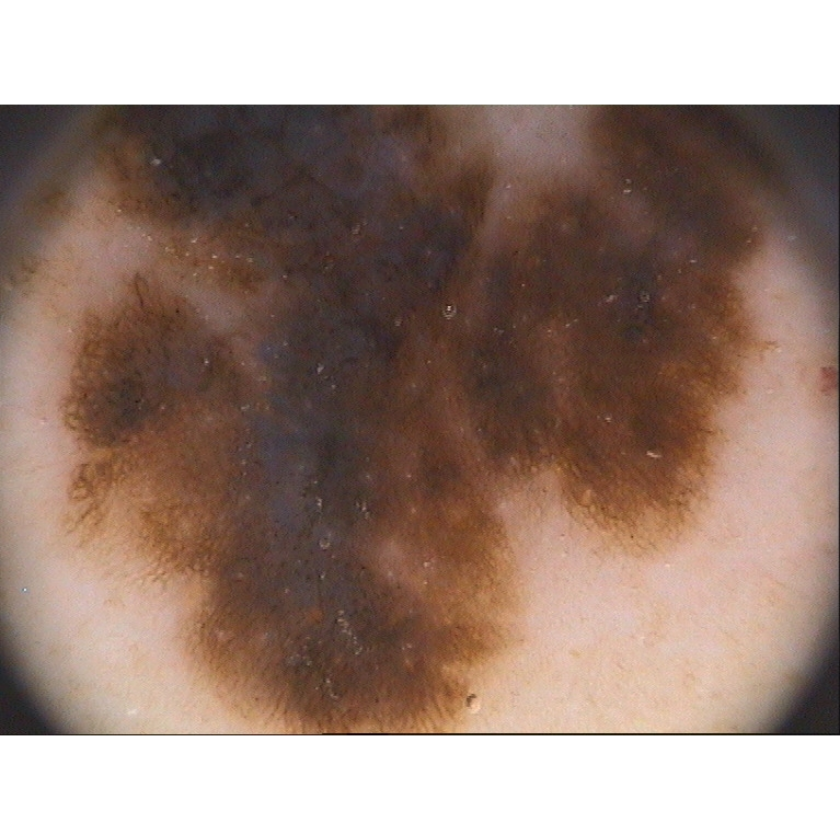

In [217]:
classification  <- classify_image(api_key, api_endp, sample$File)

## Display the classification result
result <- content(classification, "text")
result

## Read the JPEG
jpeg <- readJPEG(sprintf("PH2Dataset/PH2 Dataset images/%s/%s_Dermoscopic_Image/%s.jpg", sample$Name, sample$Name, sample$Name))
## Display the JPEG
grid.raster(jpeg)

That's a lot of matches, why? Because we have asked Watson to classify the image based on the default set of classifiers, i.e. existing models which are built-in Watson Visual Recognition and which we can use without having to train any specific classifier; what we want though is to ask Watson to only use the classifier we trained and nothing else: for this we will submit a _parameters_ file which should contain the `classifier_id` of our model.

Let's create the file:

In [218]:
## Create the JSON string, save it and display it
parameters <- "parameters.json"
write(toJSON(list(classifier_ids=classifier_id)), parameters)
print(readLines(parameters), quote=FALSE)

[1] {"classifier_ids":["melanoma_73887723"]}


We can now ask Watson to give us the classification based solely on our classifier:

In [219]:
## Ask for classification 
classification  <- classify_image(api_key, api_endp, parameters, sample$File)

## The request is in binary so we first obtain the text part of the content
result <- fromJSON(content(classification, "text"))

No encoding supplied: defaulting to UTF-8.


We got our first answer from Watson's Visual Recognition using our model; let's see how what it is:

In [220]:
print(result)

$custom_classes
[1] 1

$images
                                      classifiers      image
1 melanoma, 0.793446, melanoma_73887723, melanoma IMD080.jpg

$images_processed
[1] 1



The result will vary: if it didn't match then there will be no indication of "melanoma" in the output, meaning that for Watson the image is of a benign lesion. We can parse the result to produce a more understandable output.

In [221]:
if (class(result$images$classifiers[[1]][1]) == "data.frame")
    {
        ## Only a positive match returns a data frame
        sample$Watson = 2
        sample$Score = result$images$classifiers[[1]]$classes[[1]]$score
        
    } else {
        
        ## A list is returned since there was no match
        sample$Watson = 0
        sample$Score = "NA"
        
    }

 sprintf("Sample image was %s, Watson identified it as %s (score %s)", sample$Clinical.Diagnosis, sample$Watson, sample$Score)

[1] "Sample image was 2, Watson identified it as 2 (score 0.793446)"

Depending on the specific sample we can get a match, a false positive or a false negative (type I and type II error), which will influence _specificity_ and _sensibility_ as we will see.

## Classify all the test cases

To see how accurate is our mode we must now classify all images and store the result so we can latter analyse the results. We will want to store the reply Watson provides along with the score so we'll add two new columns to the testing set. To make the process as clear as possible I've added more `print` statements than usual

In [222]:
## Add new columns to store results
testing_set$Watson  <- ""
testing_set$Score  <- ""

sprintf("Looping to %s", nrow(testing_set))
for (i in 1:nrow(testing_set))
{
    case <- testing_set[i, ]
    classification  <- classify_image(api_key, api_endp, parameters, case$File)
    result <- fromJSON(content(classification, "text"))
    print(result)

    ## Depending on the reply we have a match or not
    if (class(result$images$classifiers[[1]][1]) == "data.frame")
        {
            ## Only a positive match returns a data frame
            testing_set[i, ]$Watson = 2
            testing_set[i, ]$Score = result$images$classifiers[[1]]$classes[[1]]$score
            
        } else {

            ## A list is returned since there was no match
            testing_set[i, ]$Watson = 0
            
        }
    
    print(sprintf("Sample image was %s, Watson identified it as %s (score %s)", testing_set[i, ]$Clinical.Diagnosis, testing_set[i, ]$Watson, testing_set[i, ]$Score))

}

[1] "Looping to 36"

No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD009.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD016.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD038.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD112.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD132.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD135.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD144.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD146.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD156.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD159.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD175.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD182.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD105.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD160.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD197.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD203.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD207.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD364.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD372.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD379.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD380.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD390.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD392.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD394.jpg

$images_processed
[1] 1

[1] "Sample image was 0, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
                                      classifiers      image
1 melanoma, 0.872022, melanoma_73887723, melanoma IMD058.jpg

$images_processed
[1] 1

[1] "Sample image was 2, Watson identified it as 2 (score 0.872022)"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
                                      classifiers      image
1 melanoma, 0.545717, melanoma_73887723, melanoma IMD061.jpg

$images_processed
[1] 1

[1] "Sample image was 2, Watson identified it as 2 (score 0.545717)"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
                                      classifiers      image
1 melanoma, 0.793446, melanoma_73887723, melanoma IMD080.jpg

$images_processed
[1] 1

[1] "Sample image was 2, Watson identified it as 2 (score 0.793446)"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD088.jpg

$images_processed
[1] 1

[1] "Sample image was 2, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD091.jpg

$images_processed
[1] 1

[1] "Sample image was 2, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
                                      classifiers      image
1 melanoma, 0.843554, melanoma_73887723, melanoma IMD168.jpg

$images_processed
[1] 1

[1] "Sample image was 2, Watson identified it as 2 (score 0.843554)"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD211.jpg

$images_processed
[1] 1

[1] "Sample image was 2, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
                                      classifiers      image
1 melanoma, 0.822479, melanoma_73887723, melanoma IMD404.jpg

$images_processed
[1] 1

[1] "Sample image was 2, Watson identified it as 2 (score 0.822479)"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD405.jpg

$images_processed
[1] 1

[1] "Sample image was 2, Watson identified it as 0 (score )"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
                                      classifiers      image
1 melanoma, 0.867222, melanoma_73887723, melanoma IMD419.jpg

$images_processed
[1] 1

[1] "Sample image was 2, Watson identified it as 2 (score 0.867222)"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
                                      classifiers      image
1 melanoma, 0.846541, melanoma_73887723, melanoma IMD420.jpg

$images_processed
[1] 1

[1] "Sample image was 2, Watson identified it as 2 (score 0.846541)"


No encoding supplied: defaulting to UTF-8.


$custom_classes
[1] 1

$images
  classifiers      image
1        NULL IMD426.jpg

$images_processed
[1] 1

[1] "Sample image was 2, Watson identified it as 0 (score )"


## Analysing the results

We now have all the data in our data frame and can make some quick analysis right away by comparing the `Clinical.Diagnosis` field with the `Watson` one:

In [223]:
testing_set[, c("Name","Clinical.Diagnosis","Watson","Score") ]

Name   Clinical.Diagnosis Watson Score   
2   IMD009 0                  0              
3   IMD016 0                  0              
8   IMD038 0                  0              
16  IMD112 0                  0              
19  IMD132 0                  0              
21  IMD135 0                  0              
22  IMD144 0                  0              
23  IMD146 0                  0              
27  IMD156 0                  0              
28  IMD159 0                  0              
31  IMD175 0                  0              
33  IMD182 0                  0              
41  IMD105 0                  0              
47  IMD160 0                  0              
51  IMD197 0                  0              
53  IMD203 0                  0              
56  IMD207 0                  0              
58  IMD364 0                  0              
62  IMD372 0                  0              
66  IMD379 0                  0              
67  IMD380 0                  0              
73  IMD390 0                  0              
74  IMD392 0                  0              
75  IMD394 0                  0              
161 IMD058 2                  2      0.872022
162 IMD061 2                  2      0.545717
166 IMD080 2                  2      0.793446
168 IMD088 2                  0              
170 IMD091 2                  0              
171 IMD168 2                  2      0.843554
172 IMD211 2                  0              
181 IMD404 2                  2      0.822479
182 IMD405 2                  0              
190 IMD419 2                  2      0.867222
193 IMD420 2                  2      0.846541
198 IMD426 2                  0

Since we are using `R` we have at our disposable the necessary tools to make a more in-depth analysis of the results, starting from a simple contingency table:

In [ ]:
## A simple table
table(testing_set$Clinical.Diagnosis, testing_set$Watson)

The `caret` library contains a useful function: `confusionMatrix`, exactely what we need to get information on the accuracy, specificity and sensibility of our model:

In [ ]:
## Confusion Matrix
confusionMatrix(table(testing_set$Clinical.Diagnosis, testing_set$Watson))

A more visual analysis is provided by a four-fold plot:

In [ ]:
## Four fold plot
fourfoldplot(table(testing_set$Clinical.Diagnosis, testing_set$Watson), conf.level = 0,margin=1, color = c("#CC6666", "#99CC99"))

The results will vary at each run since we are randomly building our training and testing set; in general the model display a very high specificity (with little or no false positives) and a sensibility that varies from very high to high (i.e. some false negatives can appear in some runs).

# Conclusion

In this workshop we went from getting a zip-file with images to having an image analysis model based on Watson's Visual Recogntion, a "deep learning" convolutional neural network that is easily available through Bluemix. We have done a lot of work but barely scratched the surface of what can be done, especially when considering that there are many other Watson APIs which can be used.

Some challenges that could very well be the basis for further workshops and experiments:

* What happens if we do not remove the "atypical nevus" entries from the training dataset?
* How does the current model classify those atypical lesions (hint: it's just a matter of reruning the classifier with a different set)
* Submitting images via a web interface for classificaiton (hint: Node RED is available on Bluemix and allows for a visual construction of flows with direct support for Watson APIs
* Applying the masks in the original database increases accuracy? (hint: this would need image conversion and saving the results from several runs; Watson Analytics could be used to analyse the final results)
* Add a natural language interface that talks to a user, asks for images, uploads them and provides the result (hint: multiple Watson APIs can be used here, from those around speech and text to Watson Conversation).

These are but some initial ideas, many more are possible and hopefully this small experiment with Visual Recognition will be a starting point.

# Bibliography

```
Bhuiyan, M. A. H., Azad, I., & Uddin, M. K. (2013). Image processing for skin cancer features extraction. International Journal of Scientific & Engineering Research, 4(2), 1–6.
Carli, P., Mannone, F., de Giorgi, V., Nardini, P., Chiarugi, A., & Giannotti, B. (2003). The problem of false-positive diagnosis in melanoma screening: the impact of dermoscopy. Melanoma Research, 13(2), 179–182.
Coll, L. R., Chinchilla, D., Coll, C., Stengel, F. M., & Cabo, H. (2010). Digital image analysis of pigmented skin lesions. Early diagnosis of melanoma. Dermatología Argentina, 14(SE), 2008; 14 (3): 200-206.
Dicker, D. T., Lerner, J., Van Belle, P., Guerry, 4th, Herlyn, M., Elder, D. E., & El-Deiry, W. S. (2006). Differentiation of normal skin and melanoma using high resolution hyperspectral imaging. Cancer Biology & Therapy, 5(8), 1033–1038.
Gutman, D., Codella, N. C., Celebi, E., Helba, B., Marchetti, M., Mishra, N., & Halpern, A. (2016). Skin Lesion Analysis toward Melanoma Detection: A Challenge at the International Symposium on Biomedical Imaging (ISBI) 2016, hosted by the International Skin Imaging Collaboration (ISIC). arXiv Preprint arXiv:1605.01397.
Linden, A. (2006). Measuring diagnostic and predictive accuracy in disease management: an introduction to receiver operating characteristic (ROC) analysis. Journal of Evaluation in Clinical Practice, 12(2), 132–139.
Mendonça, T., Ferreira, P. M., Marques, J. S., Marcal, A. R., & Rozeira, J. (2013). PH 2-A dermoscopic image database for research and benchmarking. In Engineering in Medicine and Biology Society (EMBC), 2013 35th Annual International Conference of the IEEE (pp. 5437–5440). IEEE.
Menegola, A., Fornaciali, M., Pires, R., Bittencourt, F. V., Avila, S., & Valle, E. (2017). Knowledge Transfer for Melanoma Screening with Deep Learning. arXiv Preprint arXiv:1703.07479.
Nylund, A. (2016). To be, or not to be Melanoma: Convolutional neural networks in skin lesion classification.
```
